# 摘要

商品期货期限结构的定义和经济解释, 展期收益率的定义和建模, 利用期限结构的期货交易策略

# 理论模型

关于商品期货价格形成机制（Commodity Futures Pricing）的研究主要可分成库存理论（The Theory of Storage）和现货升水理论（The Theory of Normal Backwardation，又称风险溢价理论）两大脉络。以上两种理论表明，实物商品的库存水平是期现价差（即基差或展期收益率）及期货风险溢价的根本决定因素。

## 库存因子

无论基于何种理论，库存水平均是未来价格走势的重要预测信号。因此，为准确判断期货价格走势以设计出有效的投资策略，构建库存指标尤为必要。

市场上的真实社会库存并不限于在交易所仓库中存放的交易所库存（显性库存），也包括放臵于交易所交割仓库周边地区，交割便利或经济的那部分存货（隐性库存），部分国际化商品还应考虑国外库存。交易所库存又分为期货库存（注册仓单部分）和现货库存（未注册成仓单部分）。只有已注册成仓单的部分才可以用于交割。

从理论上讲，注册仓单数在一定程度上能反映商品库存情况。但由于仓储成本和有效期差异，部分品种库存只有需要真正交割时才会被注册成仓单。比如螺纹钢、焦煤焦炭、铁矿石等在期交所的仓储成本高(焦煤焦炭 1 元/吨 * 天)，而外部仓库存放成本低，且保质期短，一般只在需要交割时才注册成仓单，其反映库存变化的信号作用较小。此外，有些农产品季节性较为明显，且仓单有效期短，会在固定时间（通常为一个作物年度）全部注销，可能存在长期无仓单数据的情况。由此可见，黑色系品种和农产品不能用注册仓单数作为库存的代理变量。

为了更好地反映商品基本面情况，结合各商品异质性及数据可得性，我们构建库存指标的优先顺序为：
1. 社会库存，包括港口库存、主要城市库存等；
2. 交易所库存，包括上海期货交易所（SHFE）、伦敦金属交易所（LME）、纽约商业交易所（COMEX）等国内外主要交易所的总库存，由注册成仓单的期货库存和未注册成仓单的现货库存两部分构成；
3. 期货库存（仓单），主要针对在大商所和郑商所上市且无社会库存数据的非农品种。其中，农产品由于每年收获时间固定且存储难度高、保质期短，期货库存不能较准确地反映总库存，信号作用较弱。因此，仅存在期货库存而无社会库存或交易所库存指标的农产品不在我们的投资品种范围内。



# 实证分析

In [1]:
# coding=utf-8
import sys
sys.path.append("C:\\Users\\hushuntai\\svn\\python")
sys.path.append("D:\\HST\\QuantStudio")
import datetime as dt

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook

import QuantStudio.api as QS
WDB = QS.FactorDB.WindDB2();

## 单资产跨期策略

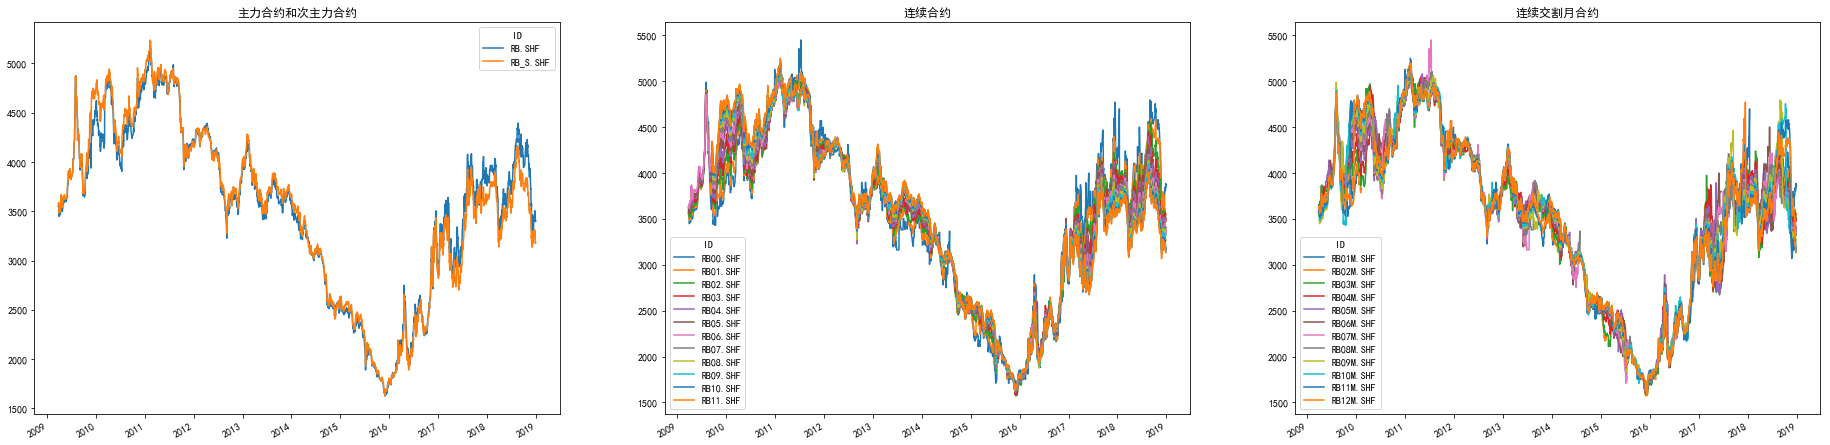

In [4]:
# 参数设置和数据准备
Exchange, ExchangeSuffix = "SHFE", "SHF"# 交易所
FutureCode = "RB"# 期货代码
StartDT = dt.datetime(2009, 3, 27)# 回测开始时间
EndDT = dt.datetime(2018, 12, 31)# 回测截止时间

WDB.connect()
# 主力和次主力合约 ID
MID, SID = FutureCode+"."+ExchangeSuffix, FutureCode+"_S."+ExchangeSuffix
# 连续合约和连续交割月合约 ID
CCIDs = pd.Series(WDB.getFutureID(future_code=FutureCode, date=None, is_current=True, contract_type="连续合约"))
CMIDs, CCIDs = CCIDs[CCIDs.str.findall("\d+M").apply(bool)].tolist(), CCIDs[~CCIDs.str.findall("\d+M").apply(bool)].tolist()
AllIDs = [MID, SID] + CCIDs + CMIDs
# 时间序列
DTs = WDB.getTable("中国期货交易日历").getDateTime(iid=Exchange, start_dt=StartDT, end_dt=EndDT)
# 获取连续合约的价格
FT = WDB.getTable("中国商品期货日行情")
CCPrice = FT.readData(factor_names=["收盘价(元)"], ids=AllIDs, dts=DTs).iloc[0]
# 获取连续合约的月合约 ID
FT = WDB.getTable("中国期货连续(主力)合约和月合约映射表")
FutureIDMap = FT.readData(factor_names=["映射月合约Wind代码"], ids=AllIDs, dts=DTs).iloc[0]
# 获取月合约的价格
MonthIDs = FutureIDMap.values.flatten()
MonthIDs = sorted(np.unique(MonthIDs[pd.notnull(MonthIDs)]))
MonthPrice = WDB.getTable("中国商品期货日行情").readData(factor_names=["收盘价(元)"], ids=MonthIDs, dts=DTs).iloc[0]
# 获取连续合约的月合约到期日和到期时间
FT = WDB.getTable("中国期货基本资料")
LastTradeDate = FT.readData(factor_names=["最后交易日期"], ids=MonthIDs, dts=[EndDT]).iloc[0, 0]
LastTradeDate = pd.DataFrame([FutureIDMap[iID].apply(lambda x: LastTradeDate[x] if pd.notnull(x) else None) for iID in AllIDs],index=AllIDs).T
ExpirationDays = pd.DataFrame(np.nan, index=LastTradeDate.index, columns=LastTradeDate.columns)
for i, iDT in enumerate(DTs):
    ExpirationDays.iloc[i] = LastTradeDate.iloc[i].apply(lambda x: (dt.datetime.strptime(x, "%Y%m%d") - iDT).days if pd.notnull(x) else np.nan)
WDB.disconnect()

# 对连续合约的价格进行调整
AdjCCPrice = {iID: QS.Tools.Strategy.genContinuousContractPrice(FutureIDMap[iID], MonthPrice, adj_direction="前复权", adj_type="收益率不变", rollover_ahead=True) for iID in AllIDs}
AdjCCPrice = pd.DataFrame(AdjCCPrice).loc[:, CCPrice.columns]

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
CCPrice.loc[:, [MID, SID]].plot(ax=Axes[0], title="主力合约和次主力合约")
CCPrice.loc[:, CCIDs].plot(ax=Axes[1], title="连续合约")
CCPrice.loc[:, CMIDs].plot(ax=Axes[2], title="连续交割月合约");

Average Annualized Roll Return: 0.26%
----------- Roll Return ADF Test -----------
Statistic : -2.844146
pvalue : 0.052239
usedlag : 5


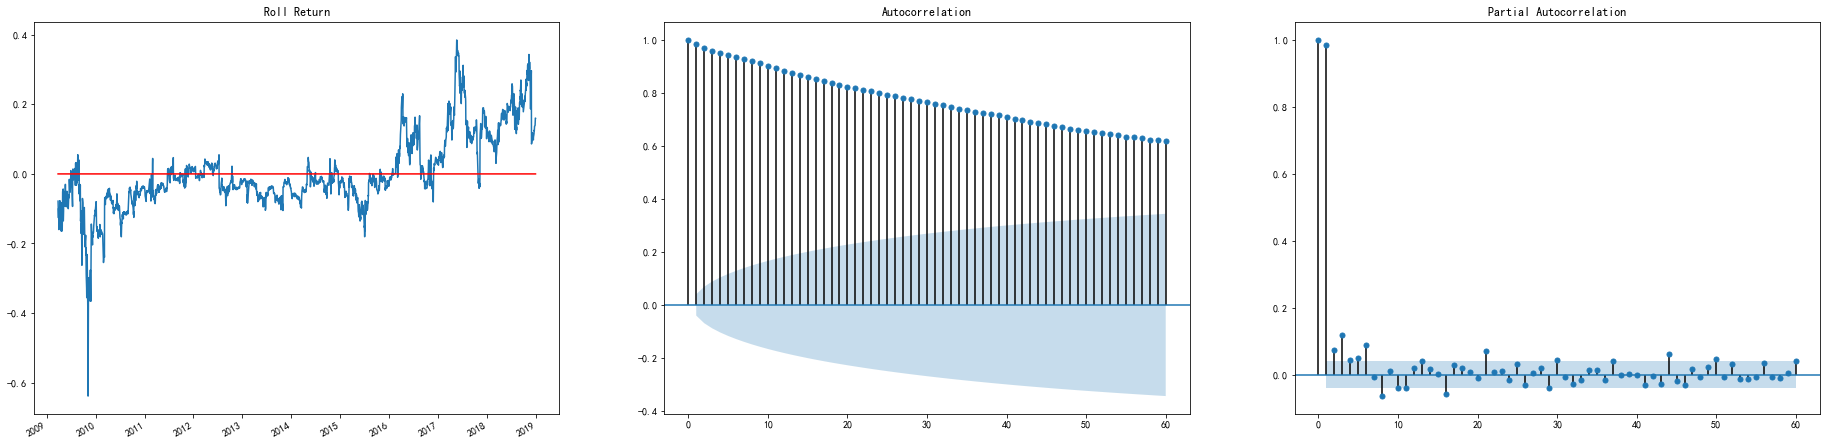

In [6]:
# 使用主力合约和次主力合约估计展期收益率
Fun = lambda x: (dt.datetime.strptime(x.iloc[0], "%Y%m%d") - dt.datetime.strptime(x.iloc[1], "%Y%m%d")).days / 365 if (pd.notnull(x.iloc[0]) and pd.notnull(x.iloc[1])) else np.nan
TimeDelta = LastTradeDate.loc[:, [MID, SID]].apply(Fun, axis=1)
RollYield = np.diff(np.log(CCPrice.loc[:, [MID, SID]]), axis=1)[:, 0] / TimeDelta
print("Average Annualized Roll Return: %.2f%%" % (RollYield.mean()*100, ))

# 平稳性检验
# ADF 检验
ADFTest = sm.tsa.stattools.adfuller(RollYield[pd.notnull(RollYield)].values, regression='c', autolag="BIC")
print("----------- Roll Return ADF Test -----------",
      ("Statistic : %f" % ADFTest[0]), 
      ("pvalue : %f" % ADFTest[1]), 
      ("usedlag : %d" % ADFTest[2]), sep="\n")

Fig, Axes = plt.subplots(1, 3, figsize=(32, 8))
RollYield.plot(ax=Axes[0], title="Roll Return")
Axes[0].plot(RollYield.index, np.zeros(RollYield.shape), color="r")
sm.graphics.tsa.plot_acf(RollYield[pd.notnull(RollYield)].values, lags=60, ax=Axes[1])
sm.graphics.tsa.plot_pacf(RollYield[pd.notnull(RollYield)].values, lags=60, ax=Axes[2]);

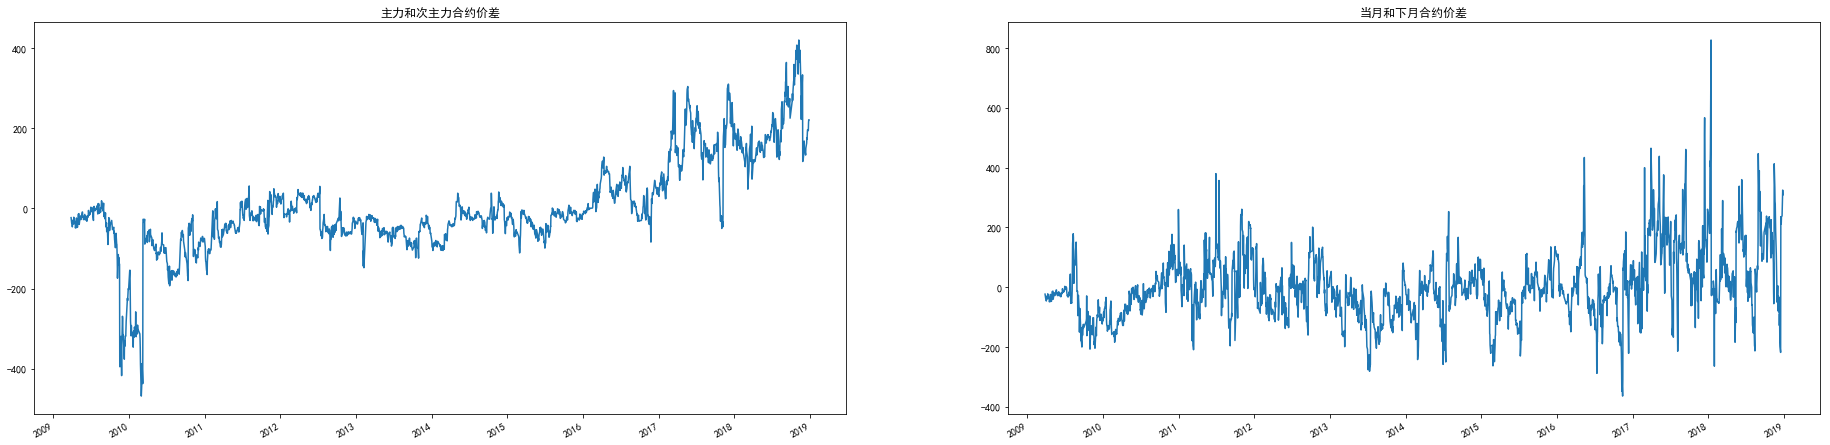

In [9]:
# 价差序列
MSSpread = CCPrice.iloc[:, 0] - CCPrice.iloc[:, 1]
C01Spread = CCPrice.loc[:, CCIDs[0]] - CCPrice.loc[:, CCIDs[1]]

Fig, Axes = plt.subplots(1, 2, figsize=(32, 8))
MSSpread.plot(ax=Axes[0], title="主力和次主力合约价差")
C01Spread.plot(ax=Axes[1], title="当月和下月合约价差");

# References

[<a id="cit-Chan:2013" href="#call-Chan:2013">Chan:2013</a>] Ernest Chan, ``_Algorithmic trading: winning strategies and their rationale_'',  2013.

